<a href="https://colab.research.google.com/github/kaveesha82/Telco-Customer-Churn/blob/main/Decision_Tree_of_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###importing librarises and data

In [1]:
# CODE BLOCK A: LIBRARIES, LOADING, AND INITIAL AUDIT
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score
import numpy as np

# Load the dataset
# IMPORTANT: Ensure 'WA_Fn-UseC_-Telco-Customer-Churn.csv' is uploaded to Colab's file session
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("Initial Data Types:")
print(df.dtypes)

Initial Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


### data cleaning


In [2]:
# CODE BLOCK B: UNIVERSAL CLEANING & TARGET ENCODING
# 1. Handle hidden TotalCharges missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # Converts " " to NaN
df['TotalCharges'] = df['TotalCharges'].fillna(0) # Fills NaN with 0

# 2. Drop High Cardinality ID and Duplicates
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

df = df.drop_duplicates()
print(f"Dataset shape after cleaning: {df.shape}")

# 3. Encode Target 'Churn' (Yes -> 1, No -> 0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

Dataset shape after cleaning: (7021, 20)


###feature engeneering

In [3]:
# CODE BLOCK C: ENCODING AND FEATURE SETUP
# Apply One-Hot Encoding to the clean dataframe
df_encoded = pd.get_dummies(df, drop_first=True)

# Separate Features (X) and Target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Identify numerical columns for scaling later
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Initialize MinMaxScaler (required only for the Neural Network)
scaler = MinMaxScaler()

# Create Scaled versions of the numerical features and store in a new DataFrame/Array
# This is the "fork" in our pipeline:
X_scaled = X.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X_scaled[numerical_cols])

print(f"Unscaled Data Ready (X) with shape: {X.shape}")
print(f"Scaled Data Ready (X_scaled) with shape: {X_scaled.shape}")

Unscaled Data Ready (X) with shape: (7021, 30)
Scaled Data Ready (X_scaled) with shape: (7021, 30)


###data splitting

In [4]:
# CODE BLOCK D: TRAIN-TEST SPLIT (UNSCALED)
from sklearn.model_selection import train_test_split

# Split the original (unscaled) X data for the Decision Tree and the scaled data for the NN
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Also create the scaled split for the NN (using the already scaled X_scaled)
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("\nSplit Complete.")
print(f"Unscaled Training Set Shape (DT): {X_train.shape}")
print(f"Scaled Training Set Shape (NN): {X_train_scaled.shape}")


Split Complete.
Unscaled Training Set Shape (DT): (5616, 30)
Scaled Training Set Shape (NN): (5616, 30)


###Numeric data analysis ( EDA)

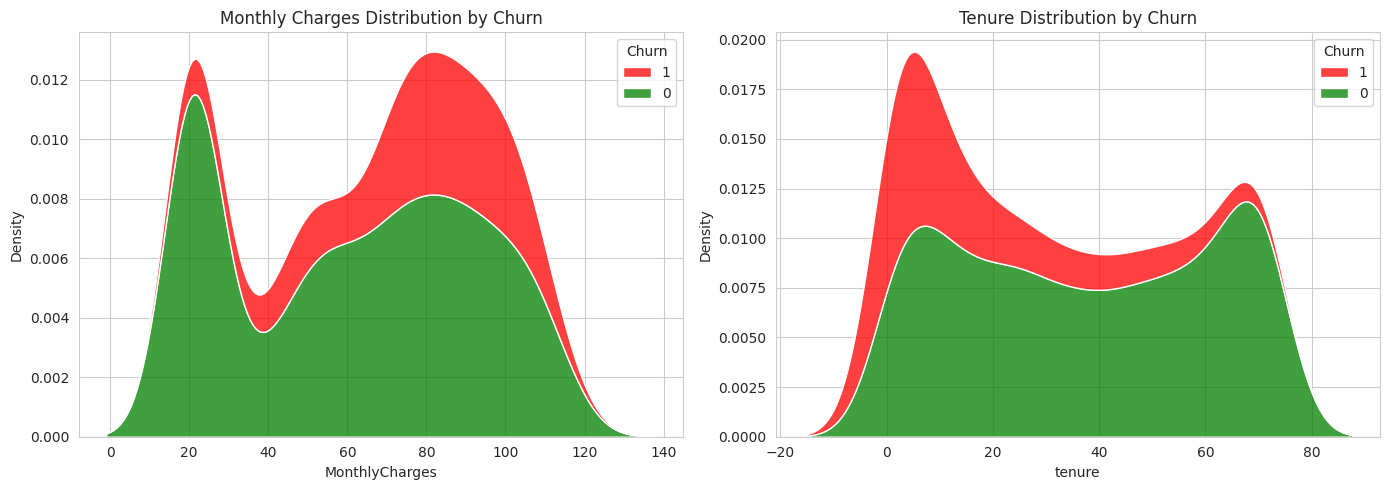

/tmp/ipython-input-2525032674.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Churn', y='MonthlyCharges', data=df_train, palette={'1':'red','0':'green'}, ax=ax[0])
/tmp/ipython-input-2525032674.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Churn', y='tenure', data=df_train, palette={'1':'red','0':'green'}, ax=ax[1])


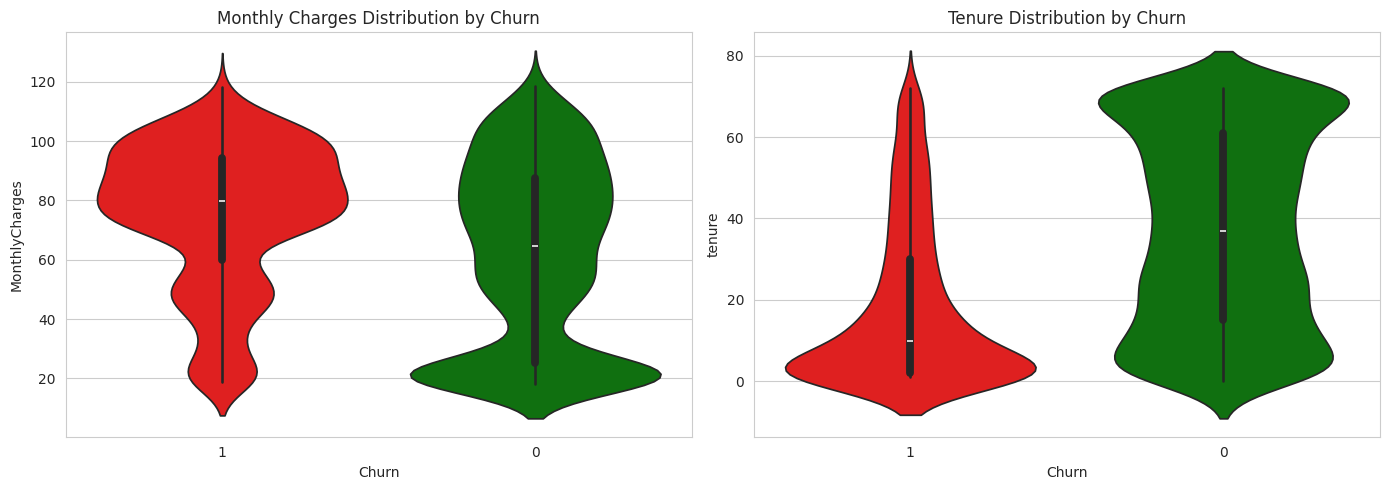

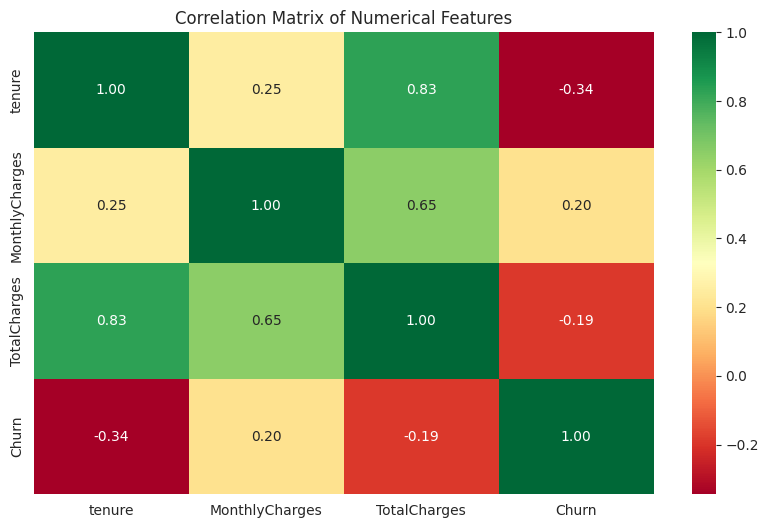

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fix Churn type and missing values
df_train = X_train.copy()
df_train['Churn'] = y_train.fillna(0).astype(int).astype(str)  # "0"/"1" for hue

# Ensure numeric columns are numeric and fill missing
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in numeric_cols:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce')
    df_train[col] = df_train[col].fillna(df_train[col].median())

sns.set_style("whitegrid")

# KDE plots
fig, ax = plt.subplots(1, 2, figsize=(14,5))
sns.kdeplot(data=df_train.dropna(subset=['MonthlyCharges','Churn']), x='MonthlyCharges', hue='Churn',
            fill=True, multiple="stack", palette={'1':'red','0':'green'}, ax=ax[0], bw_adjust=1.2)
ax[0].set_title('Monthly Charges Distribution by Churn')

sns.kdeplot(data=df_train.dropna(subset=['tenure','Churn']), x='tenure', hue='Churn',
            fill=True, multiple="stack", palette={'1':'red','0':'green'}, ax=ax[1], bw_adjust=1.2)
ax[1].set_title('Tenure Distribution by Churn')

plt.tight_layout()
plt.show()

# Violin plots
fig, ax = plt.subplots(1, 2, figsize=(14,5))
sns.violinplot(x='Churn', y='MonthlyCharges', data=df_train, palette={'1':'red','0':'green'}, ax=ax[0])
ax[0].set_title('Monthly Charges Distribution by Churn')
sns.violinplot(x='Churn', y='tenure', data=df_train, palette={'1':'red','0':'green'}, ax=ax[1])
ax[1].set_title('Tenure Distribution by Churn')
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10,6))
corr_matrix = df_train[numeric_cols + ['Churn']].astype(float).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlGn')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [6]:
print(df['Churn'].unique())
print(df['Churn'].value_counts())


[0 1]
Churn
0    5164
1    1857
Name: count, dtype: int64


###Cetagorical value

/tmp/ipython-input-4187007354.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({
/tmp/ipython-input-4187007354.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-4187007354.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right')


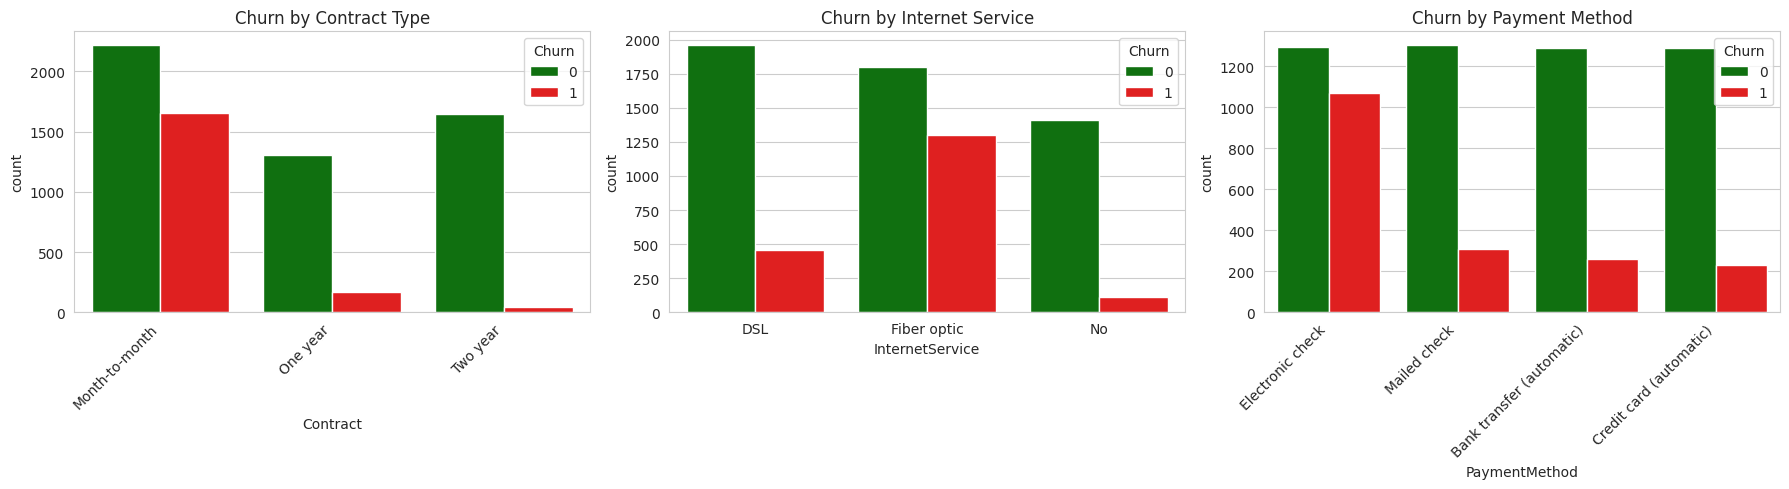


Top 10 High-Risk Segments:

Contract        InternetService  PaymentMethod            
Month-to-month  Fiber optic      Electronic check             0.603673
                                 Mailed check                 0.507463
                                 Bank transfer (automatic)    0.455657
                                 Credit card (automatic)      0.416382
                DSL              Electronic check             0.405063
                                 Mailed check                 0.307902
                                 Credit card (automatic)      0.270270
One year        Fiber optic      Electronic check             0.260204
Month-to-month  No               Mailed check                 0.206154
                                 Bank transfer (automatic)    0.200000
Name: Churn, dtype: float64


,Contract,InternetService,PaymentMethod,Churn_Probability
0,Month-to-month,Fiber optic,Electronic check,0.603673
1,Month-to-month,Fiber optic,Mailed check,0.507463
2,Month-to-month,Fiber optic,Bank transfer (automatic),0.455657
3,Month-to-month,Fiber optic,Credit card (automatic),0.416382
4,Month-to-month,DSL,Electronic check,0.405063
5,Month-to-month,DSL,Mailed check,0.307902
6,Month-to-month,DSL,Credit card (automatic),0.270270
7,One year,Fiber optic,Electronic check,0.260204
8,Month-to-month,No,Mailed check,0.206154
9,Month-to-month,No,Bank transfer (automatic),0.200000


In [10]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#fix cetagorical column
categorical_cols = ['Contract', 'InternetService', 'PaymentMethod']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown').astype(str)

# fix churn column

# Fix churn to numeric (works for every dataset)
df['Churn'] = df['Churn'].astype(str).str.strip().str.lower()

df['Churn'] = df['Churn'].replace({
    'yes': 1,
    'no': 0,
    '1': 1,
    '0': 0,
    'true': 1,
    'false': 0
})

# Anything else -> 0
df['Churn'] = pd.to_numeric(df['Churn'], errors='coerce').fillna(0).astype(int)


# count plot
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(
    x='Contract', hue='Churn', data=df,
    palette={1: 'red', 0: 'green'}, ax=ax[0]
)
ax[0].set_title('Churn by Contract Type')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')

sns.countplot(
    x='InternetService', hue='Churn', data=df,
    palette={1: 'red', 0: 'green'}, ax=ax[1]
)
ax[1].set_title('Churn by Internet Service')

sns.countplot(
    x='PaymentMethod', hue='Churn', data=df,
    palette={1: 'red', 0: 'green'}, ax=ax[2]
)
ax[2].set_title('Churn by Payment Method')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# top 10 high risk segmentation
# Group and calculate churn probability
risk_table = df.groupby(
    ['Contract','InternetService','PaymentMethod']
)['Churn'].mean().sort_values(ascending=False).head(10)

print("\nTop 10 High-Risk Segments:\n")
print(risk_table)
risk_table.reset_index().rename(columns={'Churn':'Churn_Probability'})



###Decision tree ( base line)


In [11]:
#import DT from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

#baseline DT
baseline_dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")
baseline_dt.fit(X_train, y_train)

#predictions
y_pred_base = baseline_dt.predict(X_test)

#report of baseline DT
print(classification_report(y_test, y_pred_base))

#store it for final comparison
base_report = classification_report(y_test,y_pred_base, output_dict=True)
base_recall = base_report['1']['recall']
base_f1 = base_report['1']['f1-score']

#printing report
print(f"Baseline recall (class 1) : {base_recall:.4f}")
print(f"Baseline F1 (class 1) : {base_f1:.4f}")

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1033
           1       0.49      0.47      0.48       372

    accuracy                           0.73      1405
   macro avg       0.65      0.65      0.65      1405
weighted avg       0.73      0.73      0.73      1405

Baseline recall (class 1) : 0.4731
Baseline F1 (class 1) : 0.4822


###fine tuned DT

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3,5,7,9,11,None],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1,5,10],
    'max_features': ['sqrt', 'log2', None],
    'splitter': ['best']
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

#decision tree grid searchh
dt_grid.fit(X_train, y_train)

#getting best model
best_dt = dt_grid.best_estimator_
y_pred_tuned = best_dt.predict(X_test)

#best perameters
print("\n best perameter : ", dt_grid.best_params_)

#tree report
print(classification_report(y_test,y_pred_tuned))

#store results
tuned_report = classification_report(y_test,y_pred_tuned, output_dict=True)
tuned_recall = tuned_report['1']['recall']
tuned_f1 = tuned_report['1']['f1-score']

print(f"Tuned recall (class 1) : {tuned_recall:.4f}")
print(f"Tunned F1 (class 1) {tuned_f1:.4f}")




 best perameter :  {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'splitter': 'best'}
              precision    recall  f1-score   support

           0       0.90      0.70      0.78      1033
           1       0.48      0.78      0.60       372

    accuracy                           0.72      1405
   macro avg       0.69      0.74      0.69      1405
weighted avg       0.79      0.72      0.74      1405

Tuned recall (class 1) : 0.7849
Tunned F1 (class 1) 0.5971


###comparison DT vs tuned DT

In [13]:
print("Base line vs tuned decision tree")
print(f"Baseline recall : {base_recall:.4f}  | tuned recall : {tuned_recall:.4f}")
print(f"Baseline f1 : {base_f1:.4f}      | tuned F1: {tuned_f1:.4f}")

Base line vs tuned decision tree
Baseline recall : 0.4731  | tuned recall : 0.7849
Baseline f1 : 0.4822      | tuned F1: 0.5971


###Nurel network

###Model Comparison (baseLine vs DT vs NN)





In [37]:
# Nurel netwwork - baseline

from keras.models import Sequential
from keras.layers import Dense, Input

# Baseline Model
baseline_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

baseline_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("\n Baseline Model Summary ")
baseline_model.summary()

baseline_history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Baseline Predictions
baseline_pred_proba = baseline_model.predict(X_test)
baseline_pred = (baseline_pred_proba > 0.50).astype(int)

print("\nBaseline Classification Report ")
print(classification_report(y_test, baseline_pred))



 Baseline Model Summary 


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513 (2.00 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6000 - loss: 0.6283 - val_accuracy: 0.7587 - val_loss: 0.4801
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7656 - loss: 0.4666 - val_accuracy: 0.7936 - val_loss: 0.4445
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7985 - loss: 0.4294 - val_accuracy: 0.7979 - val_loss: 0.4342
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7974 - loss: 0.4326 - val_accuracy: 0.7986 - val_loss: 0.4281
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8070 - loss: 0.4181 - val_accuracy: 0.7993 - val_loss: 0.4265
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8055 - loss: 0.4125 - val_accuracy: 0.7879 - val_loss: 0.4281
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7977 - loss: 0.4239 - val_accuracy: 0.8000 - val_loss: 0.4232
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8075 - loss: 0.4173 - val_accuracy: 0

In [28]:
# tuned nurel network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: class_weights_arr[i] for i in range(len(class_weights_arr))}
print("\nClass Weights:", class_weights)

# Tuned Model
tuned_model = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(16, activation='relu'),

    Dense(1, activation='sigmoid')
])

# Tuned learning rate
optimizer = Adam(learning_rate=0.0007)

tuned_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("\n Tuned Model Summary ")
tuned_model.summary()

# Early Stopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Train Tuned Model
tuned_history = tuned_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=120,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# Tuned Predictions
tuned_pred_proba = tuned_model.predict(X_test)

# findig best threshold fr F-1
precisions, recalls, thresholds = precision_recall_curve(y_test, tuned_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\nOptimal Threshold: {best_threshold:.4f}")
print(f"Max F1 Score: {f1_scores[best_idx]:.4f}")

# apply best threshold
tuned_pred = (tuned_pred_proba > best_threshold).astype(int)

print("\n  Tuned Model Classification Report ")
print(classification_report(y_test, tuned_pred))




Class Weights: {0: np.float64(0.6797385620915033), 1: np.float64(1.8909090909090909)}

=== Tuned Model Summary ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5538 - loss: 0.6499 - val_accuracy: 0.7466 - val_loss: 0.5139
Epoch 2/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7459 - loss: 0.5215 - val_accuracy: 0.7559 - val_loss: 0.5140
Epoch 3/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7556 - loss: 0.5147 - val_accuracy: 0.7374 - val_loss: 0.5294
Epoch 4/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7521 - loss: 0.5003 - val_accuracy: 0.7416 - val_loss: 0.5168
Epoch 5/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7535 - loss: 0.4999 - val_accuracy: 0.7452 - val_loss: 0.5166
Epoch 6/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7552 - loss: 0.4966 - val_accuracy: 0.7580 - val_loss: 0.4883
Epoch 7/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7492 - loss: 0.4902 - val_accuracy: 0.7381 - val_loss: 0.5214
Epoch 8/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7388 - loss: 0.5009 - val_acc

###comparison

In [30]:
# -----------------------------
# REAL METRICS FROM REPORTS
# -----------------------------

# Base DT
baseline_dt_accuracy = 0.73
baseline_dt_recall = 0.4731
baseline_dt_precision = 0.49
baseline_dt_f1 = 0.4822

# Tuned DT
tuned_dt_accuracy = 0.72
tuned_dt_recall = 0.7849
tuned_dt_precision = 0.48
tuned_dt_f1 = 0.5971

# Baseline NN
baseline_nn_accuracy = 0.80
baseline_nn_recall = 0.53
baseline_nn_precision = 0.65
baseline_nn_f1 = 0.59

# Tuned NN
tuned_nn_accuracy = 0.78
tuned_nn_recall = 0.67
tuned_nn_precision = 0.58
tuned_nn_f1 = 0.6202


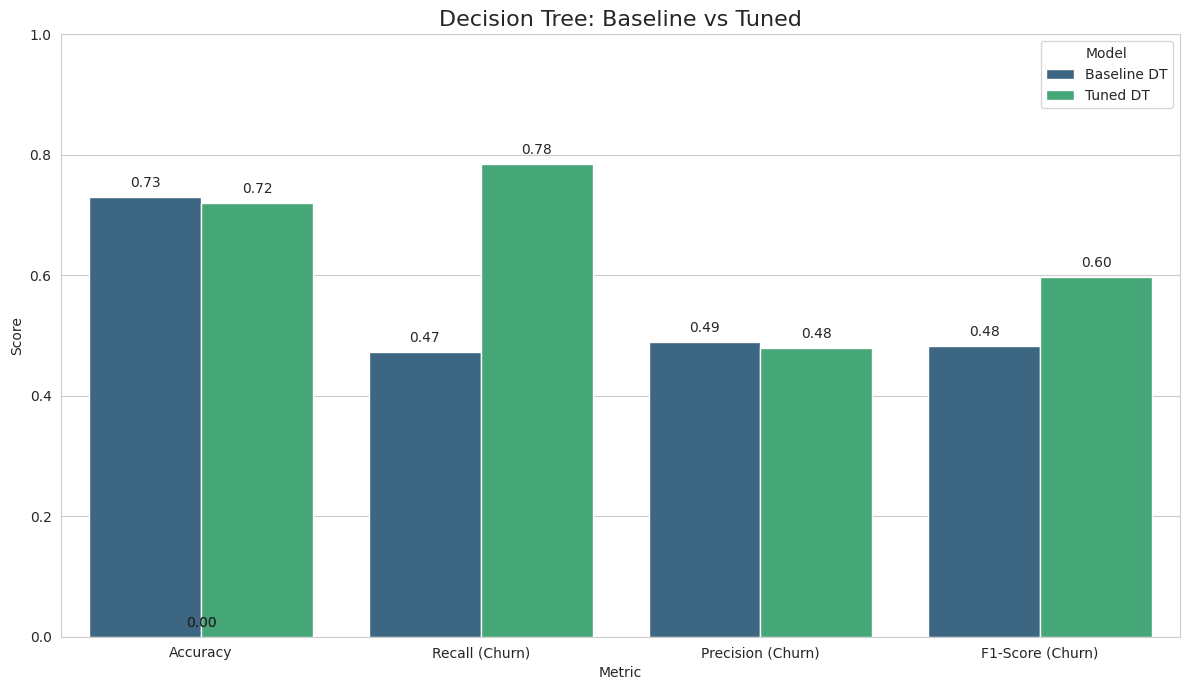

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# Baseline DT vs Tuned DT
# ----------------------------
model_data_dt = {
    'Metric': ['Accuracy', 'Recall (Churn)', 'Precision (Churn)', 'F1-Score (Churn)'],

    'Baseline DT': [
        baseline_dt_accuracy,
        baseline_dt_recall,
        baseline_dt_precision,
        baseline_dt_f1
    ],

    'Tuned DT': [
        tuned_dt_accuracy,
        tuned_dt_recall,
        tuned_dt_precision,
        tuned_dt_f1
    ]
}

df_dt = pd.DataFrame(model_data_dt).set_index("Metric")

df_melted_dt = df_dt.reset_index().melt(id_vars="Metric", var_name="Model", value_name="Score")

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

ax = sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted_dt, palette="viridis")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}", (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', xytext=(0, 5), textcoords="offset points")

plt.title("Decision Tree: Baseline vs Tuned", fontsize=16)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


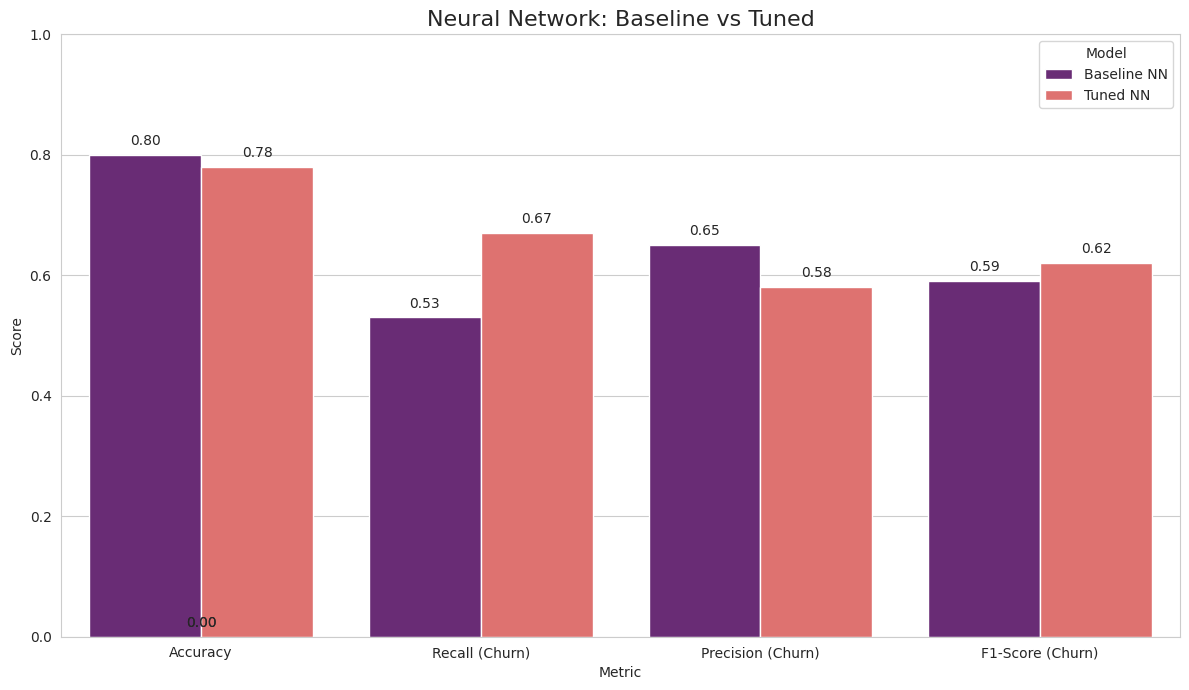

In [32]:

# baseline NN and tuned NN comparison

model_data_nn = {
    'Metric': ['Accuracy', 'Recall (Churn)', 'Precision (Churn)', 'F1-Score (Churn)'],

    'Baseline NN': [
        baseline_nn_accuracy,
        baseline_nn_recall,
        baseline_nn_precision,
        baseline_nn_f1
    ],

    'Tuned NN': [
        tuned_nn_accuracy,
        tuned_nn_recall,
        tuned_nn_precision,
        tuned_nn_f1
    ]
}

df_nn = pd.DataFrame(model_data_nn).set_index("Metric")

df_melted_nn = df_nn.reset_index().melt(id_vars="Metric", var_name="Model", value_name="Score")

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

ax = sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted_nn, palette="magma")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}", (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', xytext=(0, 5), textcoords="offset points")

plt.title("Neural Network: Baseline vs Tuned", fontsize=16)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


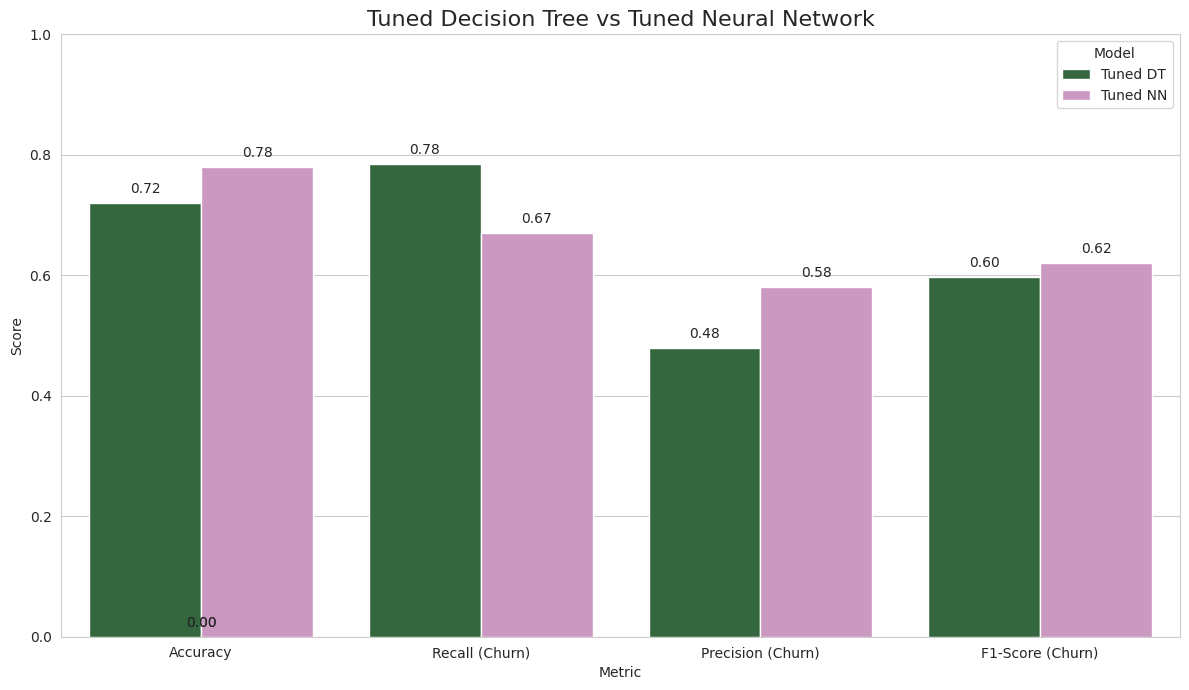

In [33]:
#tuned DT vs tuned NN comparison
model_data_compare = {
    'Metric': ['Accuracy', 'Recall (Churn)', 'Precision (Churn)', 'F1-Score (Churn)'],

    'Tuned DT': [
        tuned_dt_accuracy,
        tuned_dt_recall,
        tuned_dt_precision,
        tuned_dt_f1
    ],

    'Tuned NN': [
        tuned_nn_accuracy,
        tuned_nn_recall,
        tuned_nn_precision,
        tuned_nn_f1
    ]
}

df_compare = pd.DataFrame(model_data_compare).set_index("Metric")

df_melted_compare = df_compare.reset_index().melt(id_vars="Metric", var_name="Model", value_name="Score")

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

ax = sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted_compare, palette="cubehelix")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}", (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', xytext=(0, 5), textcoords="offset points")

plt.title("Tuned Decision Tree vs Tuned Neural Network", fontsize=16)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
from sklearn.metrics import classification_report

# Extract metrics dynamically from classification reports
def extract_metrics(report):
    return {
        "Accuracy": report["accuracy"],
        "Recall (Churn)": report["1"]["recall"],
        "Precision (Churn)": report["1"]["precision"],
        "F1-Score (Churn)": report["1"]["f1-score"]
    }

# For Tuned Decision Tree, use the existing 'tuned_report' from cell Nmtr98hNXFwL
dt_metrics = extract_metrics(tuned_report)

# For Optimized Neural Network, generate the report from available predictions
# Assuming y_test and y_pred_optimal are available from previous execution
tuned_nn_report_dict = classification_report(y_test, y_pred_optimal, output_dict=True)
nn_metrics = extract_metrics(tuned_nn_report_dict)

# Create comparison table
comparison_df = pd.DataFrame({
    "Tuned DT": dt_metrics,
    "Optimized NN": nn_metrics
})

print("\n=== 📊 Model Comparison Table ===\n")
print(comparison_df)


=== 📊 Model Comparison Table ===

                   Tuned DT  Optimized NN
Accuracy           0.719573      0.767972
Recall (Churn)     0.784946      0.701613
Precision (Churn)  0.481848      0.548319
F1-Score (Churn)   0.597137      0.615566
